In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
#source('tests.R')
#source("cleanup.R")
set.seed(7493)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Here we are reading the data.

In [104]:
match_data <- read_csv("data/season_2018.csv") %>% 
            mutate(FTR = as_factor(FTR)) %>% 
            mutate(FTHG = as.integer(FTHG)) %>% 
            mutate(FTAG = as.integer(FTAG)) %>% 
            mutate(HomeTeam = as_factor(HomeTeam)) %>% 
            mutate(AwayTeam = as_factor(AwayTeam)) 
match_data 

Parsed with column specification:
cols(
  .default = col_double(),
  Div = col_character(),
  Date = col_character(),
  HomeTeam = col_character(),
  AwayTeam = col_character(),
  FTR = col_character(),
  HTR = col_character(),
  Referee = col_character()
)

See spec(...) for full column specifications.



Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,⋯,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
<chr>,<chr>,<fct>,<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,⋯,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,⋯,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,⋯,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
E0,12/05/2019,Southampton,Huddersfield,1,1,D,1,0,H,⋯,2.29,22,-1.5,2.27,2.16,1.80,1.73,1.37,5.36,8.49
E0,12/05/2019,Tottenham,Everton,2,2,D,1,0,H,⋯,2.07,19,-0.5,2.13,2.08,1.85,1.80,1.91,3.81,4.15
E0,12/05/2019,Watford,West Ham,1,4,A,0,2,A,⋯,2.44,19,-0.5,2.25,2.19,1.78,1.72,2.11,3.86,3.41


In [105]:
match_split <- initial_split(match_data, prop = 3/4, strata = "FTR")  
match_train <- training(match_split)   
match_test <- testing(match_split)


Below represents the number of matches won by each home team. 

In [106]:
training_summary_netscore <- match_train %>% 
                group_by(FTR, HomeTeam, AwayTeam, FTHG, FTAG) %>%
                summarize() %>% 
                mutate(Net_Score = FTHG - FTAG)

training_summary_nwin_home <- match_train %>% 
                group_by(FTR, HomeTeam) %>%
                summarize(TotalWinsHome = n()) %>% 
                arrange(desc(TotalWinsHome))

training_summary_nwin_away <- match_train %>% 
                group_by(FTR, AwayTeam) %>%
                summarize(TotalWinsAway = n()) %>% 
                arrange(desc(TotalWinsAway))


training_summary_nwin_home
training_summary_nwin_away
training_summary_netscore

`summarise()` regrouping output by 'FTR', 'HomeTeam', 'AwayTeam', 'FTHG' (override with `.groups` argument)

`summarise()` regrouping output by 'FTR' (override with `.groups` argument)

`summarise()` regrouping output by 'FTR' (override with `.groups` argument)



FTR,HomeTeam,TotalWinsHome
<fct>,<fct>,<int>
H,Liverpool,14
H,Man City,14
H,Man United,10
⋮,⋮,⋮
D,Newcastle,1
D,Watford,1
D,Cardiff,1


FTR,AwayTeam,TotalWinsAway
<fct>,<fct>,<int>
H,Fulham,13
H,Huddersfield,12
A,Man City,12
⋮,⋮,⋮
A,Fulham,1
A,Huddersfield,1
D,Cardiff,1


FTR,HomeTeam,AwayTeam,FTHG,FTAG,Net_Score
<fct>,<fct>,<fct>,<int>,<int>,<int>
H,Man United,Leicester,2,1,1
H,Man United,Brighton,2,1,1
H,Man United,Everton,2,1,1
⋮,⋮,⋮,⋮,⋮,⋮
D,Crystal Palace,Everton,0,0,0
D,Crystal Palace,Newcastle,0,0,0
D,Crystal Palace,Arsenal,2,2,0


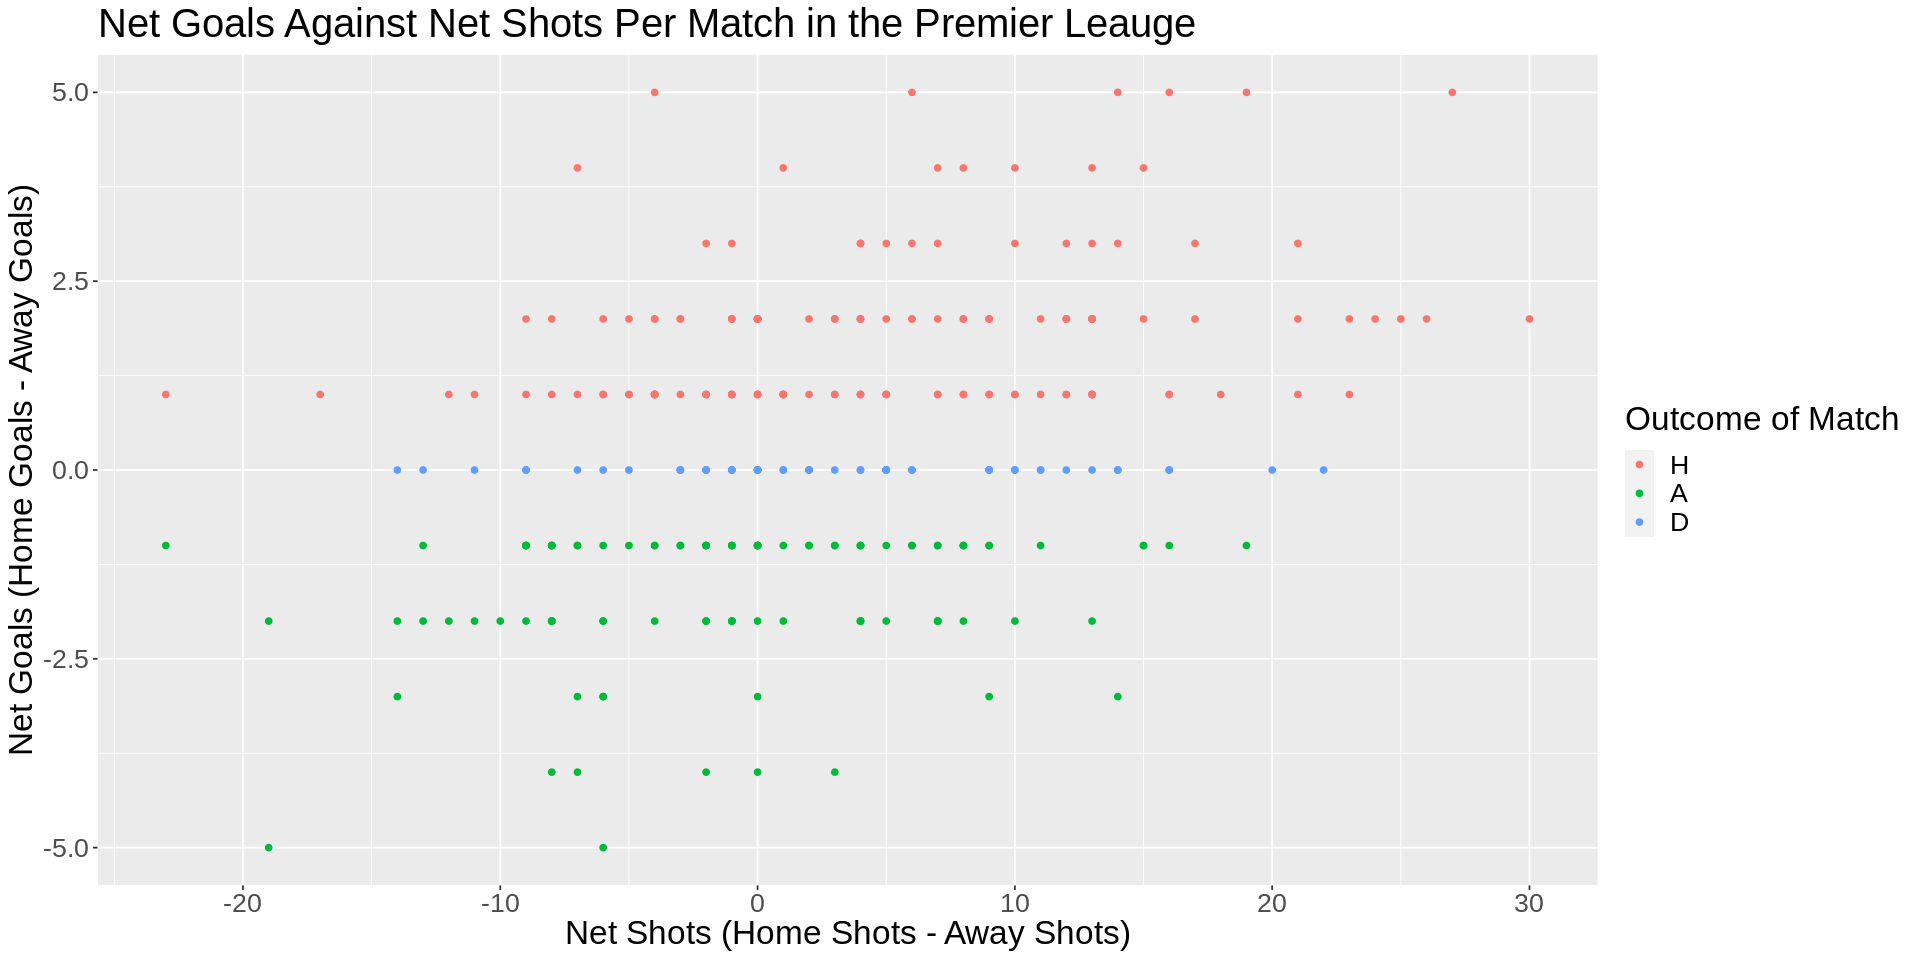

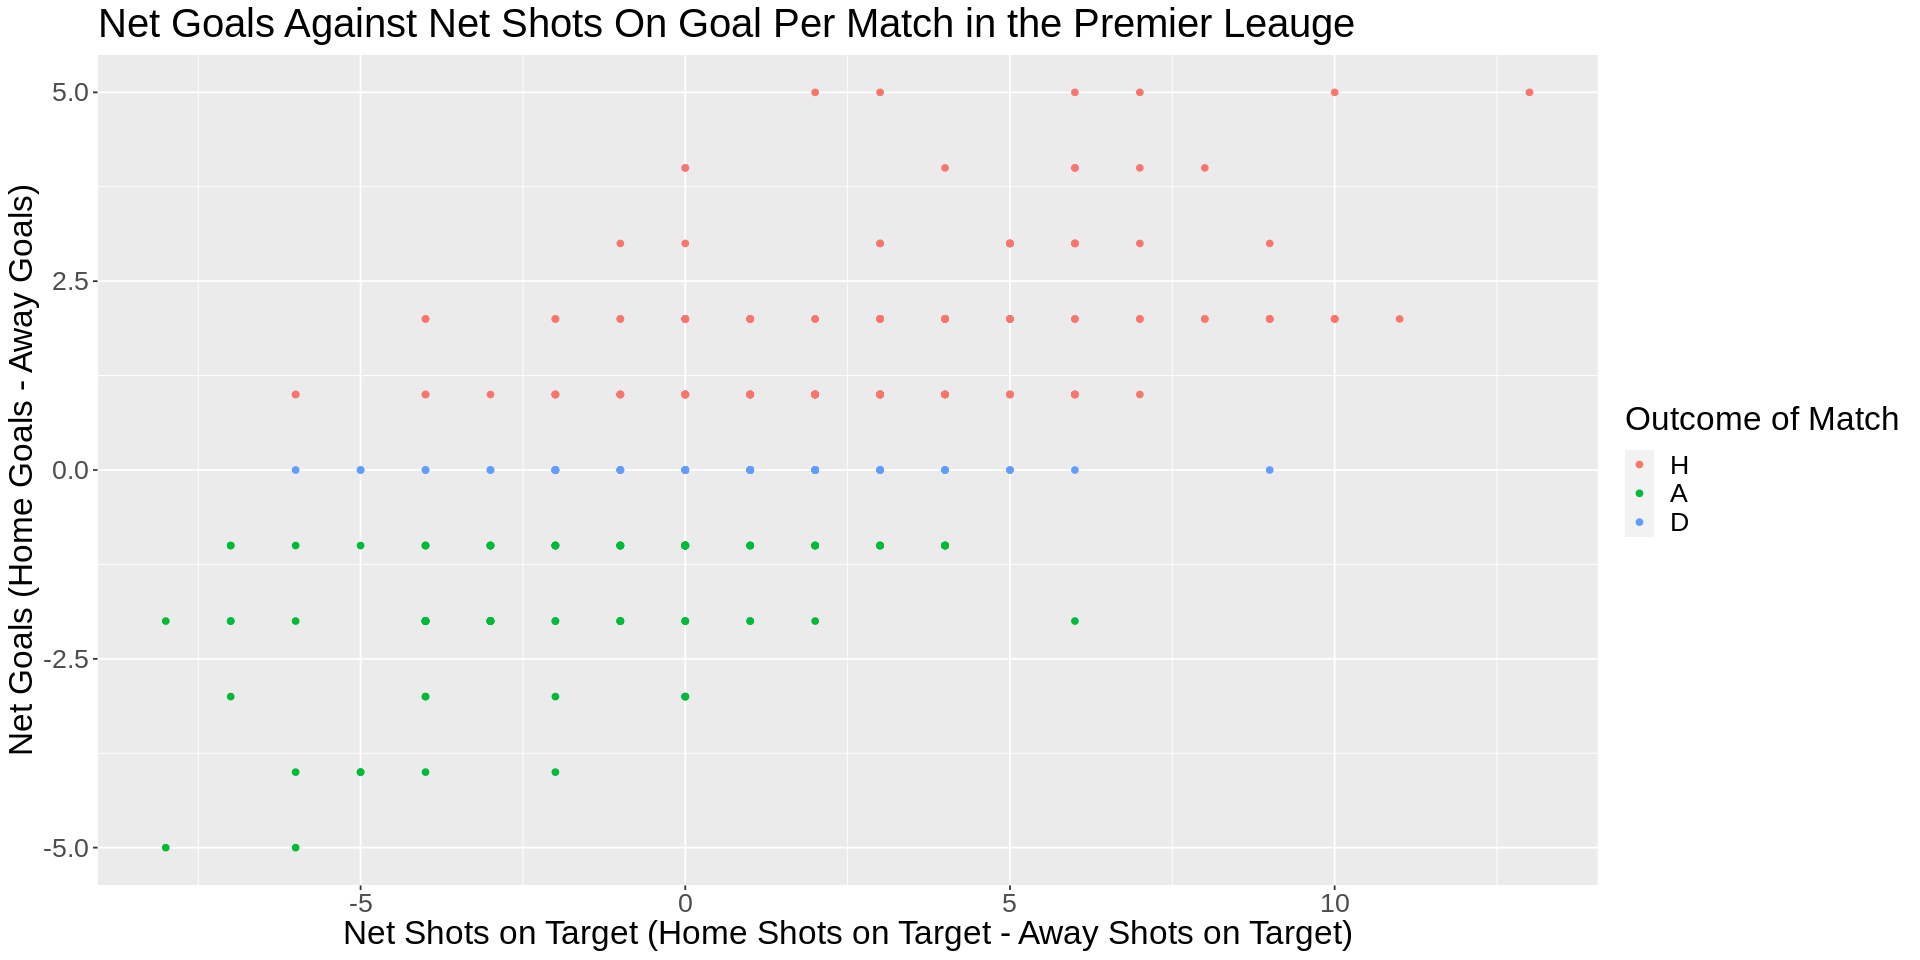

In [108]:
options(repr.plot.height = 8, repr.plot.width = 16)

netscore_vs_netshots_plot <- match_train %>% 
    mutate(NetScore = FTHG - FTAG, NetShots = HS - AS) %>% 
    ggplot(aes(x= NetShots, y = NetScore, color = FTR)) +
    geom_point() +
    labs(x= "Net Shots (Home Shots - Away Shots)", y = "Net Goals (Home Goals - Away Goals)", 
        color = "Outcome of Match") +
    ggtitle("Net Goals Against Net Shots Per Match in the Premier Leauge") +
    theme(text = element_text(size=20))

netscore_vs_netshots_ongoal_plot <- match_train %>% 
    mutate(NetScore = FTHG - FTAG, NetShotsOnGoal = HST - AST) %>% 
    ggplot(aes(x= NetShotsOnGoal, y = NetScore, color = FTR)) +
    geom_point() +
    labs(x= "Net Shots on Target (Home Shots on Target - Away Shots on Target)", 
         y = "Net Goals (Home Goals - Away Goals)",
        color = "Outcome of Match") +
    ggtitle("Net Goals Against Net Shots On Goal Per Match in the Premier Leauge") +
    theme(text = element_text(size=20))


netscore_vs_netshots_plot
netscore_vs_netshots_ongoal_plot

#### Note that:  H = Home Team Win | D = Draw/Tie | A = Away Team Win

In [3]:
Introduction
Betting on the outcomes of soccer matches is very common in the sporting community. Based on our dataset, which team is more 
likely to win and what is the given score? This project involves using halftime match statistics to predict the outcome of the 
match, as well as the final score. The given dataset provides specific match information from the 2018-2019 Premier League games
including which teams played, half-time score, shots, shots-on-target, shots that hit woodwork, corner kicks, fouls committed, 
free kicks committed, yellow and red cards given out and more factors affecting the likeliness of a goal. 


ERROR: Error in parse(text = x, srcfile = src): <text>:2:9: unexpected symbol
1: Introduction
2: Betting on
           ^


In [2]:
Method
We plan on using the following factors to conduct our data analysis:
Chosen Variables/Columns| Justification: 

FTHG and HG = Full Time Home Team Goals
Testing Data: Not used in our predictions
FTAG and AG = Full Time Away Team Goals
Testing Data: Not used in our predictions
FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)
Testing Data: Not used in our predictions
HTHG = Half Time Home Team Goals
Allows for performance assessment at half time when paired with total attempted team shots.
HTAG = Half Time Away Team Goals


HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)


HS = Home Team Shots
Combined with total team goals, total team shots allow us to further predict the accuracy of the team at halftime.
AS = Away Team Shots


HST = Home Team Shots on Target
(Shot blocked by opponent’s goalie)
This factor pair gives us an idea of how many times a team got close to the opponent’s net and the effectiveness of their 
opponent’s goalie.
AST = Away Team Shots on Target
(Shot blocked by opponent’s goalie)


HHW = Home Team Hit Woodwork
Alongside HST and AST, these factors show us how many times a team got within shooting distance of the net.
AHW = Away Team Hit Woodwork


HC = Home Team Corners
Shows a team’s accuracy and how often the team reaches the opponent’s goal.
AC = Away Team Corners


HFKC = Home Team Free Kicks Conceded


AFKC = Away Team Free Kicks Conceded


HO = Home Team Offsides
Frequency of fouls and how often the team is around the opponent’s goal
AO = Away Team Offsides




In our data analysis, we plan on visualizing our data using a scatter plot. Using a scatter plot will allow us to better 
understand the correlation between predictors (see list of columns and variables above) and net goal difference.


ERROR: Error in parse(text = x, srcfile = src): <text>:2:4: unexpected symbol
1: Method
2: We plan
      ^


In [4]:
Expected outcomes and significance
In our data analysis, we expect to successfully and accurately find the winner between two teams, alongside the final score. 
These findings could increase the probability of an accurate prediction regarding the outcome of a game between two teams. Our 
analysis can then be used to answer future questions, such as : Which team in a league has the greatest chances of winning for 
the given season?


ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected symbol
1: Expected outcomes
             ^
